In [1]:
from torchdyn.core import NeuralODE
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.utils.data as data
import torch.nn as nn
import pytorch_lightning as pl

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device = 'cpu'

cuda:0


In [17]:
def plot_l63(data, n, style="scatter"):
    x, y, z = data[:n, :].T
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    if style == "scatter":
        ax.scatter(x, y, z, s=1)
    elif style == "line":
        ax.plot(x, y, z, lw=0.3)
    else:
        raise ValueError
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"L63, {n} points")
    plt.show()

In [18]:
def get_loader(
    train_file: str,
    test_file: str,
    l63: bool,
):
    train = np.load(train_file)
    test = np.load(test_file)
    print(f"raw data shapes -- train: {train.shape}, test: {test.shape}")
    X = torch.Tensor(train[:-1, :])
    Y = torch.Tensor(train[1:, :])
    print(f"train shapes -- x: {X.shape}, y: {Y.shape}")
    if l63:
        plot_l63(train, n=1000)
        plot_l63(train, n=-1, style="line")
    train = data.TensorDataset(X, Y)
    trainloader = data.DataLoader(
        train, batch_size=1000, shuffle=True, num_workers=31
    )
    return trainloader

In [19]:
def get_loader_l63():
    return get_loader(
        train_file="lorenz63_on0.05_train.npy", test_file="lorenz63_test.npy", l63=True
    )

In [20]:
class Learner_l63(pl.LightningModule):
    def __init__(self, t_span: torch.Tensor, model: nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span
        self.trainloader = get_loader_l63()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1]  # select last point of solution trajectory
        loss = nn.MSELoss()(y_hat, y)
        return {"loss": loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return self.trainloader

In [21]:
def get_model_l63():
    layers = [
        nn.Linear(3, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3),
    ]
    f = nn.Sequential(*layers)
    model = NeuralODE(
        f,
        sensitivity="adjoint",
        solver="tsit5",
        interpolator=None,
        atol=1e-3,
        rtol=1e-3,
    ).to(device)
    t_span = torch.linspace(0, 1, 2)  # [0,1]
    return t_span, model

In [22]:
def train():
    learn = Learner_l63(*get_model_l63())
    trainer = pl.Trainer(min_epochs=200, max_epochs=250)
    trainer.fit(learn)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
raw data shapes -- train: (100000, 3), test: (100000, 3)
train shapes -- x: torch.Size([99999, 3]), y: torch.Size([99999, 3])


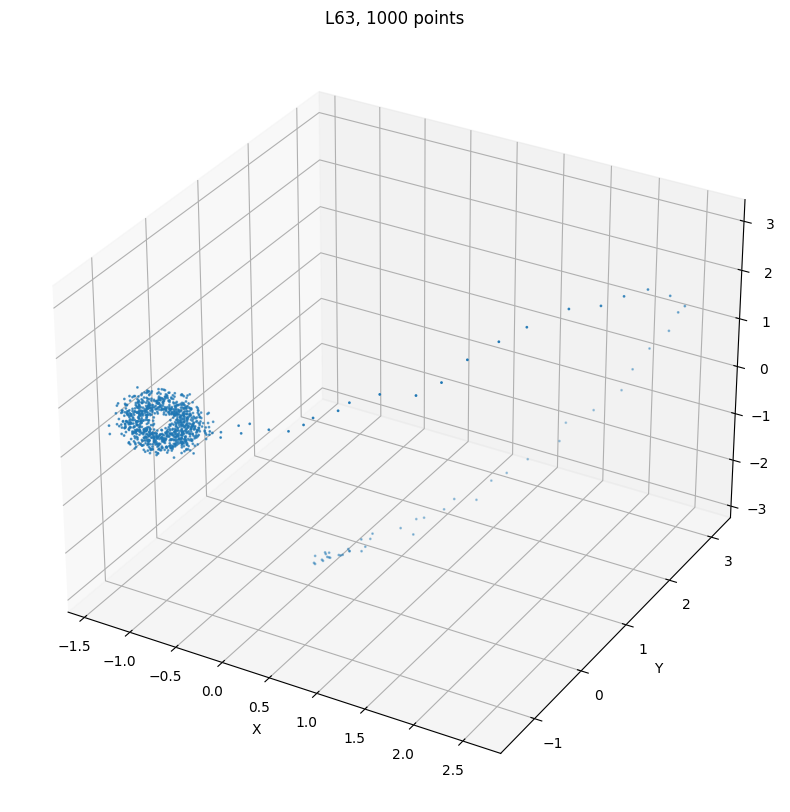

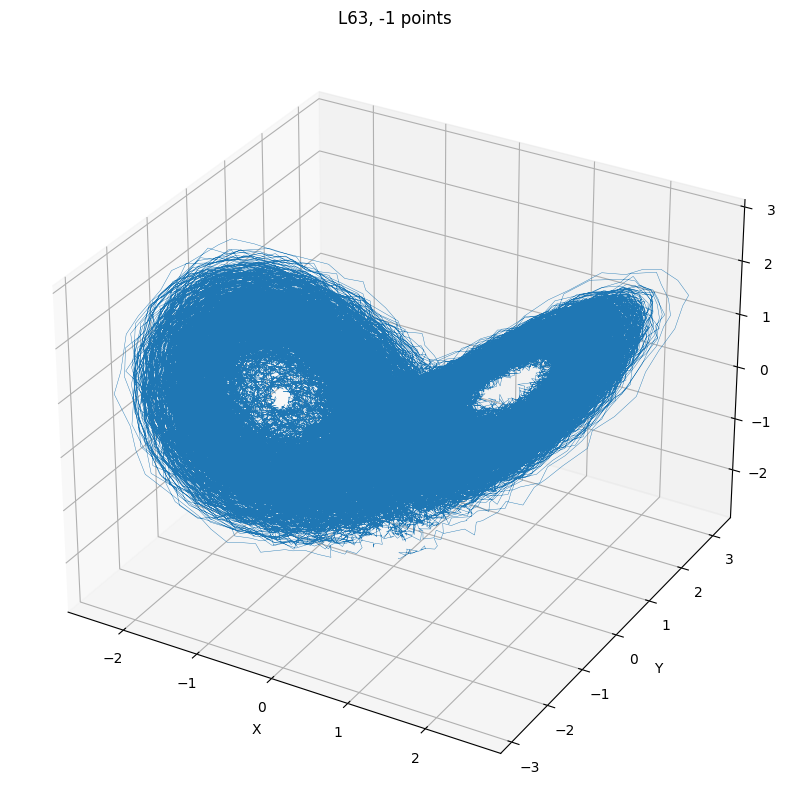

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NeuralODE | 12.9 K | train
--------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.052     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Training: |                                          | 0/? [00:00<?, ?it/s]

In [ ]:
train()

In [9]:
def get_loader_l96():
    return get_loader(
        train_file="lorenz96_on0.05_train.npy", test_file="lorenz96_test.npy", l63=False
    )